**# Model Training using AlexNet Architecture#**

In [1]:
import os
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#paths and parameters
TRAIN_DIR = '/workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/preprocessed_data/train'
VAL_DIR = '/workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/preprocessed_data/validation'
MODEL_PATH = '/workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5'
INPUT_SHAPE = (128, 128, 1)
EPOCHS = 20
BATCH_SIZE = 128
CLASS_NAMES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
CLASS_TO_IDX = {name: idx for idx, name in enumerate(CLASS_NAMES)}

In [3]:
class NPYDataGenerator(Sequence):
    def __init__(self, root_dir, class_names, class_to_idx, batch_size=32, shuffle=True):
        self.root_dir = root_dir
        self.class_names = class_names
        self.class_to_idx = class_to_idx
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.samples = []
        for class_name in class_names:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            for fname in os.listdir(class_dir):
                if fname.endswith('.npy'):
                    self.samples.append((os.path.join(class_dir, fname), class_to_idx[class_name]))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def __getitem__(self, idx):
        batch_samples = self.samples[idx * self.batch_size:(idx + 1) * self.batch_size]
        X = []
        y = []
        for fpath, label in batch_samples:
            img = np.load(fpath)
            X.append(img)
            y.append(label)
        X = np.stack(X)
        y = np.array(y)
        y = to_categorical(y, num_classes=len(self.class_names))
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.samples)

In [4]:
#Build AlexNet model
def build_my_model(input_shape=(128, 128, 1), num_classes=7):
    model = Sequential()
    model.add(Conv2D(48, (11, 11), strides=4, padding='same', input_shape=input_shape))  # 48 instead of 96
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    model.add(Conv2D(128, (5, 5), padding='same'))  # 128 instead of 256
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    model.add(Conv2D(192, (3, 3), padding='same', activation='relu'))  # 192 instead of 384
    model.add(Conv2D(192, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))  # 128 instead of 256
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))  # 512 instead of 4096
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model


In [5]:
# Create generators for training and validation
train_gen = NPYDataGenerator(TRAIN_DIR, CLASS_NAMES, CLASS_TO_IDX, batch_size=BATCH_SIZE)
val_gen = NPYDataGenerator(VAL_DIR, CLASS_NAMES, CLASS_TO_IDX, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_gen)}")
print(f"Number of validation batches: {len(val_gen)}")

Number of training batches: 226
Number of validation batches: 56


In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
#Training will stop when the validation accuracy is not improving for 3 consecutive epochs.

In [8]:
model = build_my_model(input_shape=INPUT_SHAPE, num_classes=len(CLASS_NAMES))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop]
)

/opt/conda/envs/ml-env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/envs/ml-env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.2319 - loss: 1.8369
Epoch 1: val_accuracy improved from -inf to 0.25828, saving model to /workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 195s 854ms/step - accuracy: 0.2320 - loss: 1.8366 - val_accuracy: 0.2583 - val_loss: 1.8895
Epoch 2/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.3756 - loss: 1.5738
Epoch 2: val_accuracy improved from 0.25828 to 0.42627, saving model to /workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 206s 907ms/step - accuracy: 0.3757 - loss: 1.5736 - val_accuracy: 0.4263 - val_loss: 1.5509
Epoch 3/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.4447 - loss: 1.4220
Epoch 3: val_accuracy improved from 0.42627 to 0.44891, saving model to /workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 224s 993ms/step - accuracy: 0.4448 - loss: 1.4219 - val_accuracy: 0.4489 - val_loss: 1.4376
Epoch 4/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.5012 - loss: 1.2968
Epoch 4: val_accuracy improved from 0.44891 to 0.48825, saving model to /workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 225s 993ms/step - accuracy: 0.5012 - loss: 1.2968 - val_accuracy: 0.4883 - val_loss: 1.3287
Epoch 5/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.5229 - loss: 1.2427
Epoch 5: val_accuracy did not improve from 0.48825
226/226 ━━━━━━━━━━━━━━━━━━━━ 216s 955ms/step - accuracy: 0.5229 - loss: 1.2427 - val_accuracy: 0.4679 - val_loss: 1.3692
Epoch 6/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.5418 - loss: 1.1914
Epoch 6: val_accuracy improved from 0.48825 to 0.52703, saving model to /workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.5418 - loss: 1.1914 - val_accuracy: 0.5270 - val_loss: 1.2252
Epoch 7/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.5680 - loss: 1.1290
Epoch 7: val_accuracy improved from 0.52703 to 0.53043, saving model to /workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 216s 953ms/step - accuracy: 0.5679 - loss: 1.1291 - val_accuracy: 0.5304 - val_loss: 1.2412
Epoch 8/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.5838 - loss: 1.0950
Epoch 8: val_accuracy did not improve from 0.53043
226/226 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.5837 - loss: 1.0951 - val_accuracy: 0.5123 - val_loss: 1.2520
Epoch 9/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.6046 - loss: 1.0460
Epoch 9: val_accuracy did not improve from 0.53043
226/226 ━━━━━━━━━━━━━━━━━━━━ 210s 930ms/step - accuracy: 0.6045 - loss: 1.0460 - val_accuracy: 0.5163 - val_loss: 1.2705
Epoch 10/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.6124 - loss: 1.0216
Epoch 10: val_accuracy improved from 0.53043 to 0.54755, saving model to /workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 213s 942ms/step - accuracy: 0.6124 - loss: 1.0216 - val_accuracy: 0.5476 - val_loss: 1.2171
Epoch 11/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.6368 - loss: 0.9691
Epoch 11: val_accuracy did not improve from 0.54755
226/226 ━━━━━━━━━━━━━━━━━━━━ 214s 947ms/step - accuracy: 0.6368 - loss: 0.9692 - val_accuracy: 0.5408 - val_loss: 1.2347
Epoch 12/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.6474 - loss: 0.9240
Epoch 12: val_accuracy improved from 0.54755 to 0.57218, saving model to /workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 219s 969ms/step - accuracy: 0.6474 - loss: 0.9241 - val_accuracy: 0.5722 - val_loss: 1.1776
Epoch 13/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.6689 - loss: 0.8807
Epoch 13: val_accuracy did not improve from 0.57218
226/226 ━━━━━━━━━━━━━━━━━━━━ 214s 946ms/step - accuracy: 0.6689 - loss: 0.8808 - val_accuracy: 0.5365 - val_loss: 1.2806
Epoch 14/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.6799 - loss: 0.8499
Epoch 14: val_accuracy did not improve from 0.57218
226/226 ━━━━━━━━━━━━━━━━━━━━ 222s 982ms/step - accuracy: 0.6799 - loss: 0.8499 - val_accuracy: 0.5604 - val_loss: 1.2425
Epoch 15/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.7042 - loss: 0.8008
Epoch 15: val_accuracy did not improve from 0.57218
226/226 ━━━━━━━━━━━━━━━━━━━━ 226s 998ms/step - accuracy: 0.7042 - loss: 0.8008 - val_accuracy: 0.5309 - val_loss: 1.3888
Epoch 16/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7202 - loss: 0.7534
Epoch 1

226/226 ━━━━━━━━━━━━━━━━━━━━ 220s 974ms/step - accuracy: 0.7586 - loss: 0.6442 - val_accuracy: 0.5735 - val_loss: 1.4170
Epoch 20/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.7746 - loss: 0.5983
Epoch 20: val_accuracy did not improve from 0.57345
226/226 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.7746 - loss: 0.5984 - val_accuracy: 0.5566 - val_loss: 1.3606


In [13]:
history = model.history.history

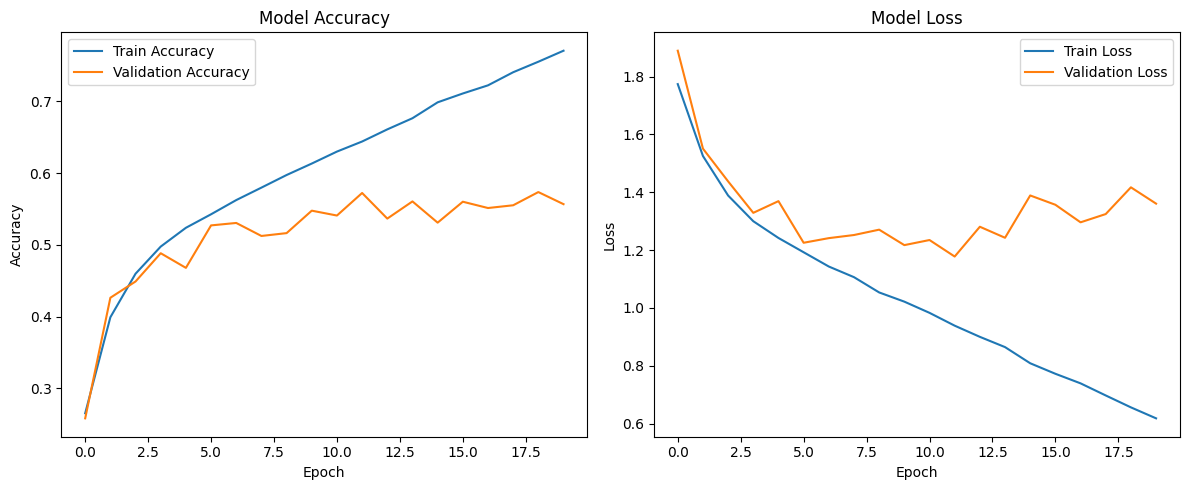

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
